<a href="https://colab.research.google.com/github/OscarOvanger/GeoDecepticon/blob/main/training_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is where the training goes down

 We start of by installing the requirements

In [1]:
!pip install numpy
!pip install torch
!pip install torchvision
!pip install matplotlib
!pip install wandb

In [2]:
!git clone https://github.com/OscarOvanger/GeoDecepticon.git

Cloning into 'GeoDecepticon'...
remote: Enumerating objects: 159, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 159 (delta 52), reused 34 (delta 34), pack-reused 100 (from 1)
Receiving objects: 100% (159/159), 3.10 MiB | 16.82 MiB/s, done.
Resolving deltas: 100% (81/81), done.


In [3]:
import os
os.chdir('/content/GeoDecepticon')

In [4]:
from dataloader import BinaryImageDataset, preprocess_image
from transformer import VisionTransformer
import torch
import torch.optim as optim
import torch.nn as nn
import wandb
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sample import reconstruct_image_from_patches
import matplotlib.colors as mcolors
from torch.optim.lr_scheduler import ReduceLROnPlateau
from matplotlib import colors
import os
from torch.optim.lr_scheduler import StepLR

training data shape:  (6000, 64, 64)
test data shape:  (3423, 64, 64)


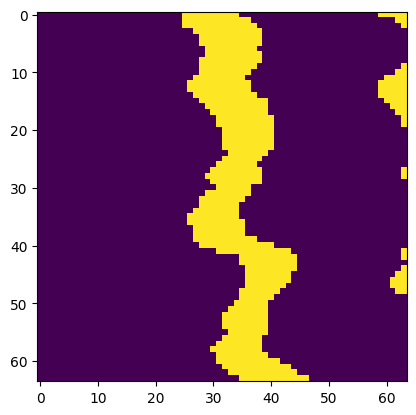

In [5]:
data_1 = np.load("data_array_1.npz")
data_2 = np.load("data_array_2.npz")
data_3 = np.load("data_array_3.npz")

data_array_1 = data_1['data_array']
data_array_2 = data_2['data_array']
data_array_3 = data_3['data_array']

training_data = np.concatenate((data_array_1, data_array_2), axis=0)
test_data = data_array_3
print("training data shape: ", training_data.shape)
print("test data shape: ", test_data.shape)

plt.imshow(training_data[0])
plt.show()

In [6]:
# Create the embedding matrix for all 2x2 binary combinations + 1 mask token
embedding_matrix = torch.zeros((17, 4))  # Shape: (num_tokens, embed_dim)

# Generate all possible 2x2 binary patches
patches = torch.tensor([
    [a, b, c, d]
    for a in range(2)
    for b in range(2)
    for c in range(2)
    for d in range(2)
])  # Shape: (16, 4) for 16 combinations of 2x2 patches

# Assign each patch's values as its embedding
for i, patch in enumerate(patches):
    embedding_matrix[i, :] = patch  # Set the embedding to the patch values

# Set the last row to all 2s for the masked patch
embedding_matrix[-1, :] = 2  # Mask token embedding


print("Embedding Matrix:\n", embedding_matrix)

Embedding Matrix:
 tensor([[0., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 0., 1., 1.],
        [0., 1., 0., 0.],
        [0., 1., 0., 1.],
        [0., 1., 1., 0.],
        [0., 1., 1., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 1.],
        [1., 0., 1., 0.],
        [1., 0., 1., 1.],
        [1., 1., 0., 0.],
        [1., 1., 0., 1.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.],
        [2., 2., 2., 2.]])


In [ ]:
# Load the model parameters
checkpoint = torch.load("checkpoints/vision_transformer_epoch_200.pth")
model.load_state_dict(checkpoint["model_state_dict"])  # Load model weights

<ipython-input-7-fc626ea2cc5d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("checkpoints/vision_transformer_epoch_200.pth")


FileNotFoundError: [Errno 2] No such file or directory: 'checkpoints/vision_transformer_epoch_200.pth'

In [ ]:
import wandb
wandb.login()

# Initialize wandb project
wandb.init(
    project="vision-transformer",
    config={
        "batch_size": batch_size,
        "embed_dim": embed_dim,
        "num_heads": num_heads,
        "feedforward_dim": feedforward_dim,
        "num_layers": num_layers,
        "num_tokens": num_tokens,
        "max_patches": max_patches,
        "dropout": dropout,
        "learning_rate": learning_rate,
        "num_epochs": num_epochs,
        "initial_mask_rate": initial_mask_rate,
        "final_mask_rate": final_mask_rate,
    },
)

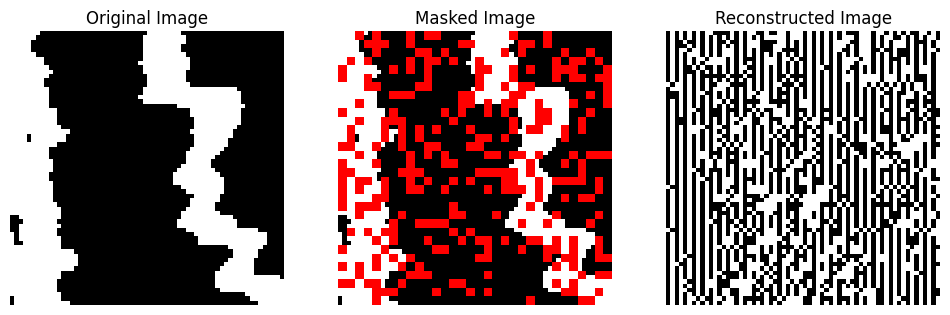

Epoch [1/1000] completed. Average Loss: 2.9729


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


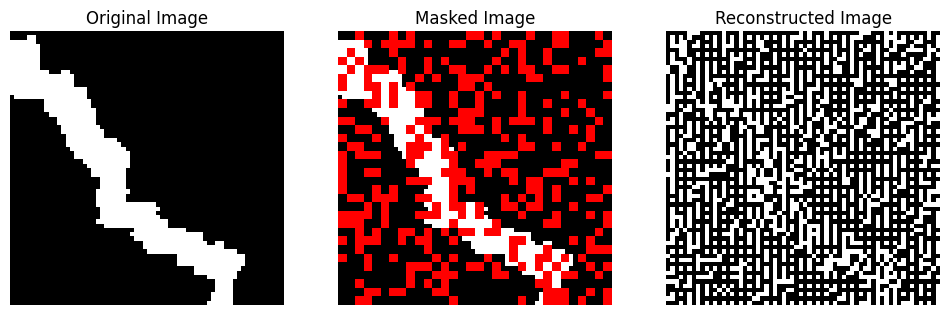

Epoch [2/1000] completed. Average Loss: 2.7340


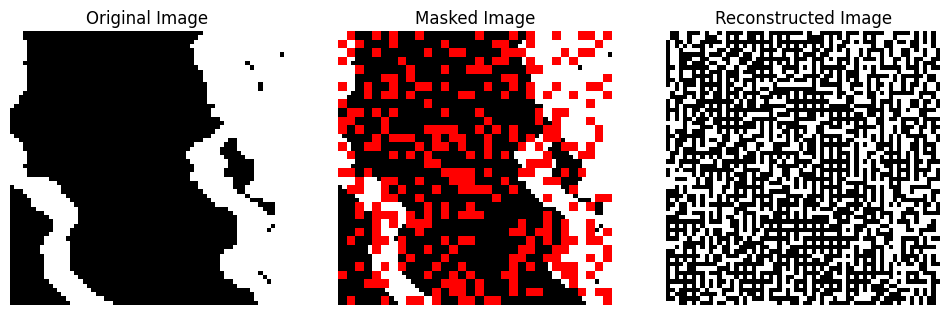

Epoch [3/1000] completed. Average Loss: 2.5310


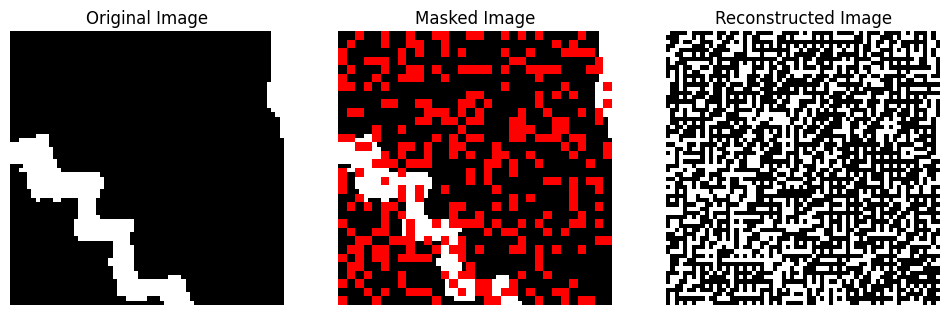

Epoch [4/1000] completed. Average Loss: 2.3121


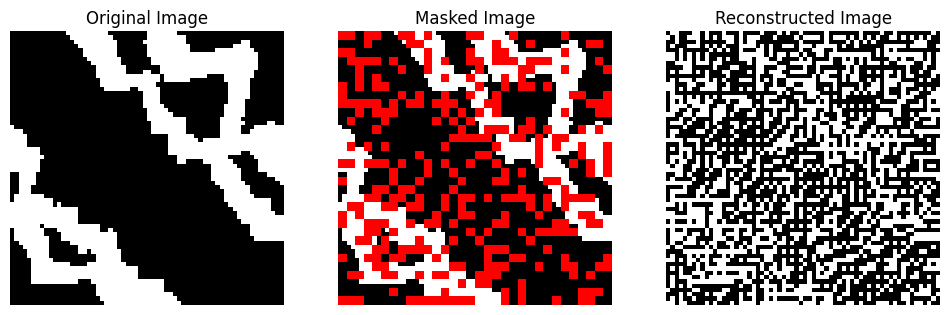

Epoch [5/1000] completed. Average Loss: 2.1475


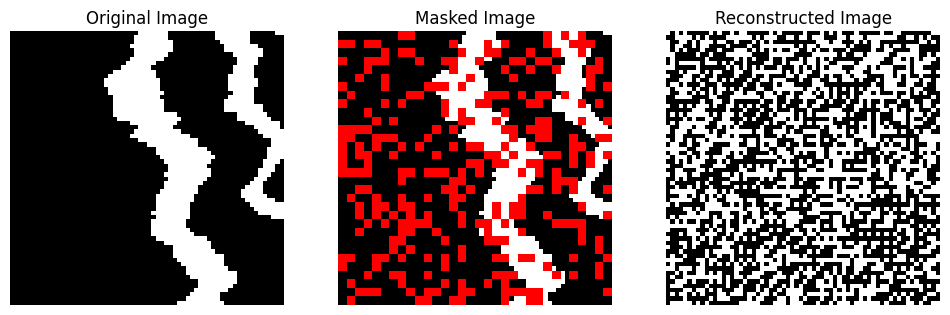

Epoch [6/1000] completed. Average Loss: 2.0034


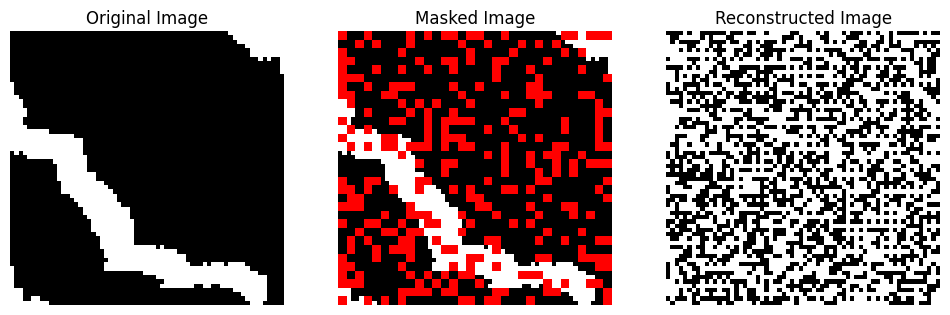

Epoch [7/1000] completed. Average Loss: 1.9021


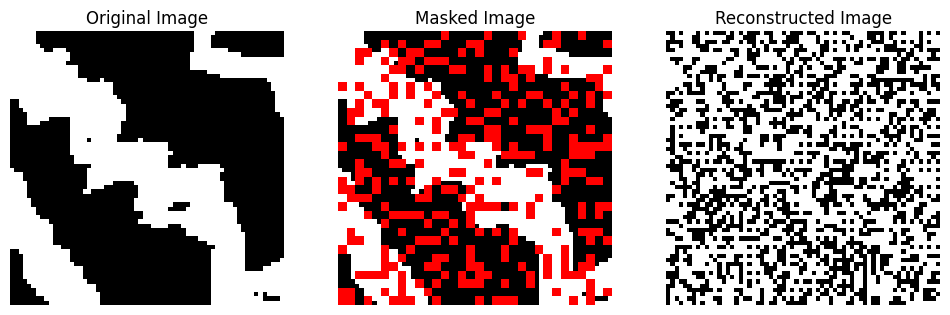

Epoch [8/1000] completed. Average Loss: 1.8246


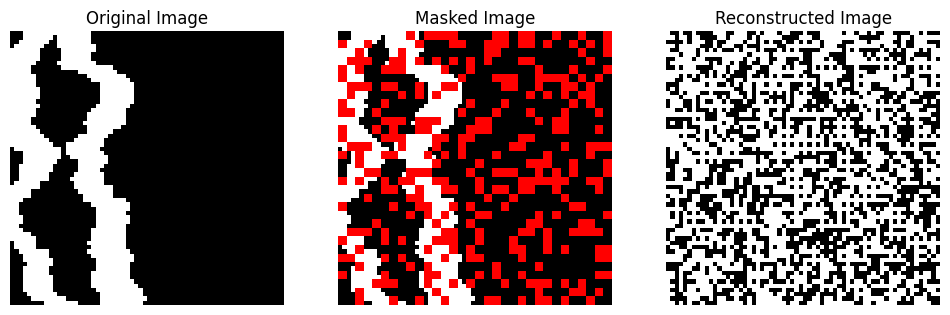

Epoch [9/1000] completed. Average Loss: 1.7621


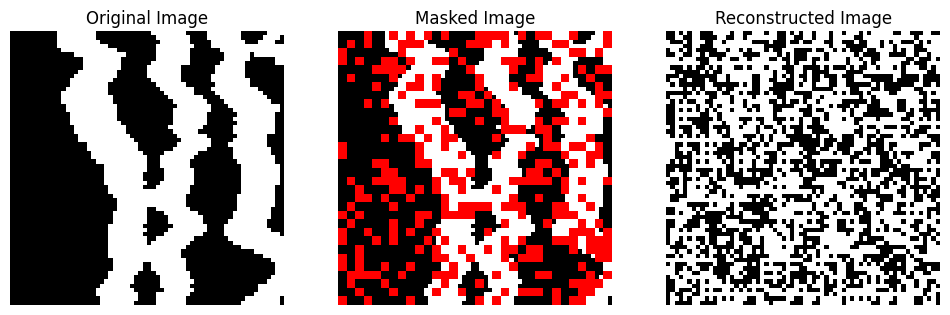

Epoch [10/1000] completed. Average Loss: 1.7135


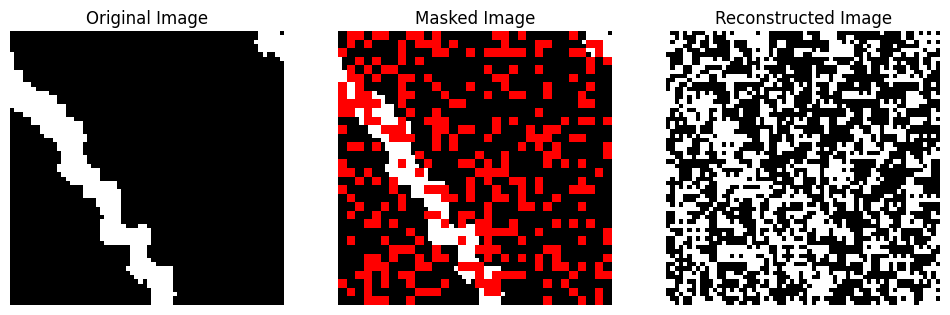

Epoch [11/1000] completed. Average Loss: 1.6685


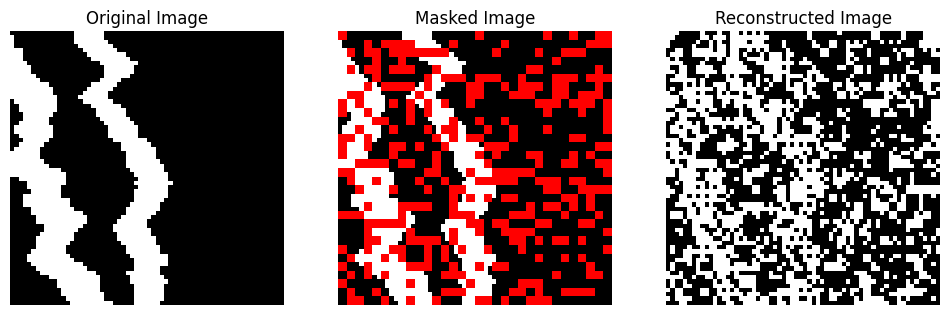

Epoch [12/1000] completed. Average Loss: 1.6437


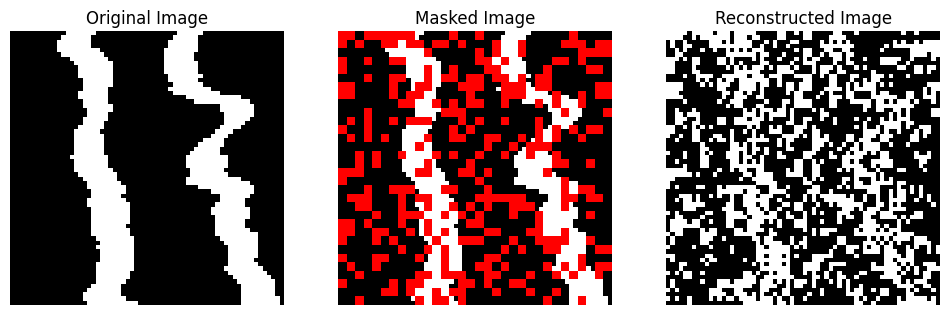

Epoch [13/1000] completed. Average Loss: 1.6129


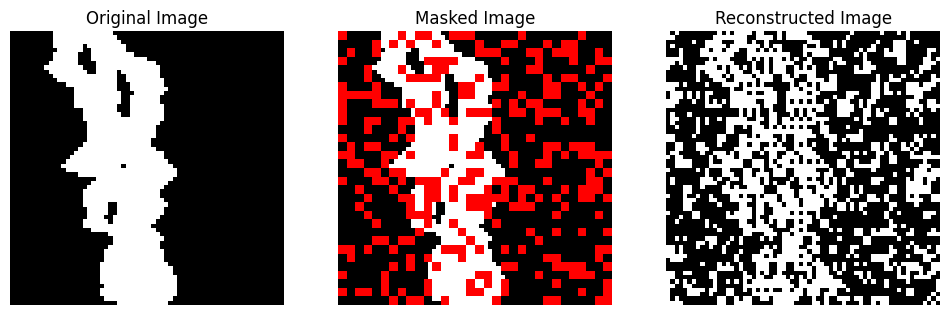

Epoch [14/1000] completed. Average Loss: 1.5855


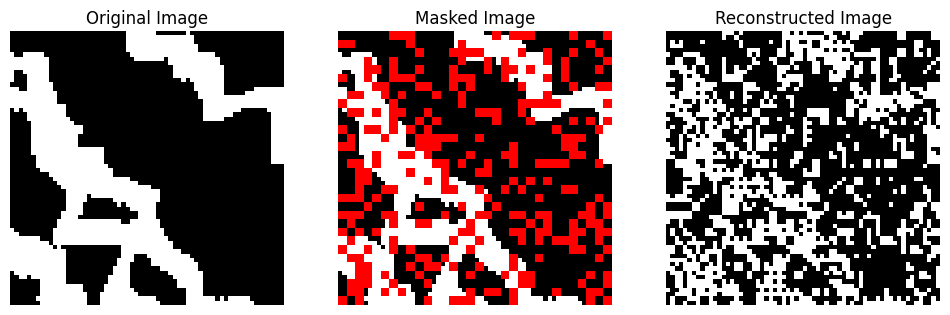

Epoch [15/1000] completed. Average Loss: 1.5639


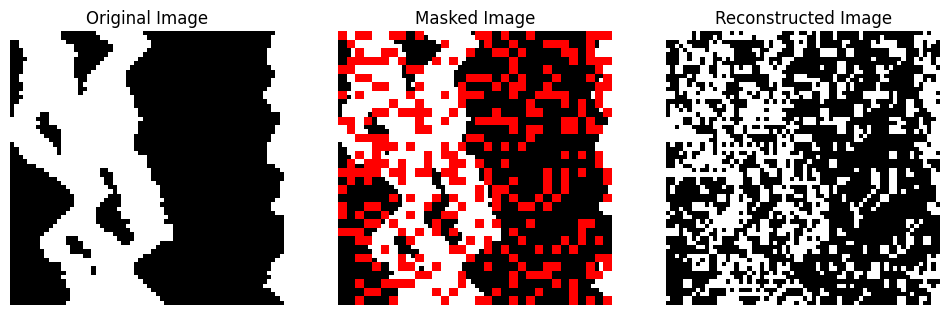

Epoch [16/1000] completed. Average Loss: 1.5470


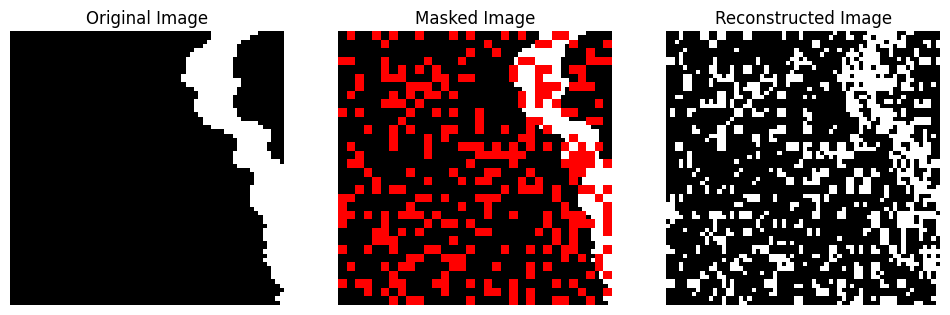

Epoch [17/1000] completed. Average Loss: 1.5210


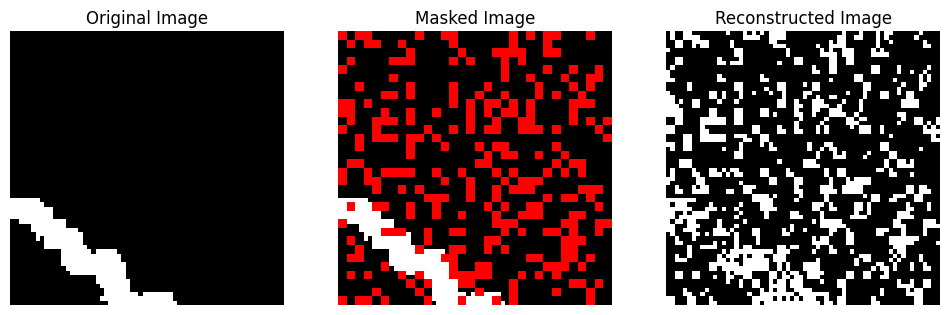

Epoch [18/1000] completed. Average Loss: 1.5180


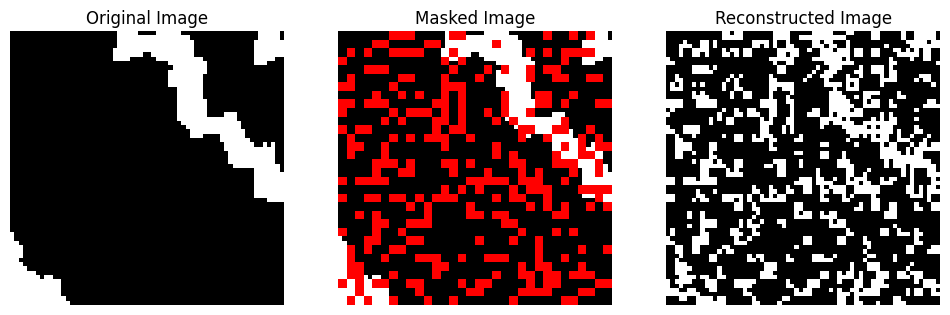

Epoch [19/1000] completed. Average Loss: 1.4987


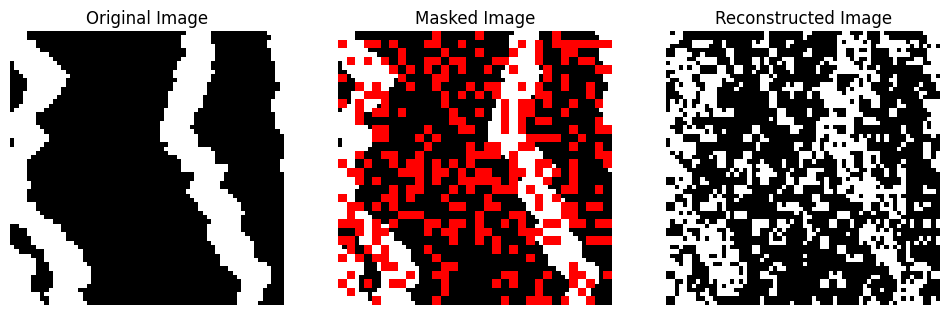

Epoch [20/1000] completed. Average Loss: 1.4839


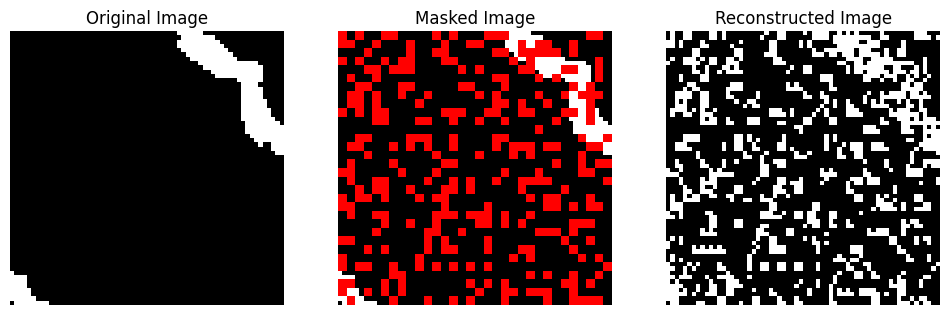

Epoch [21/1000] completed. Average Loss: 1.4710


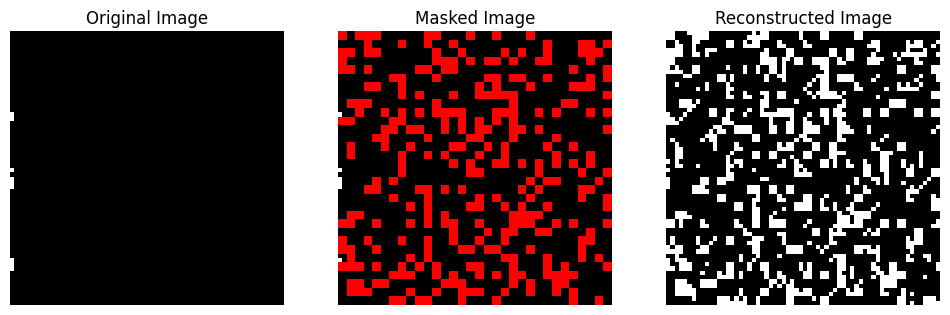

Epoch [22/1000] completed. Average Loss: 1.4476


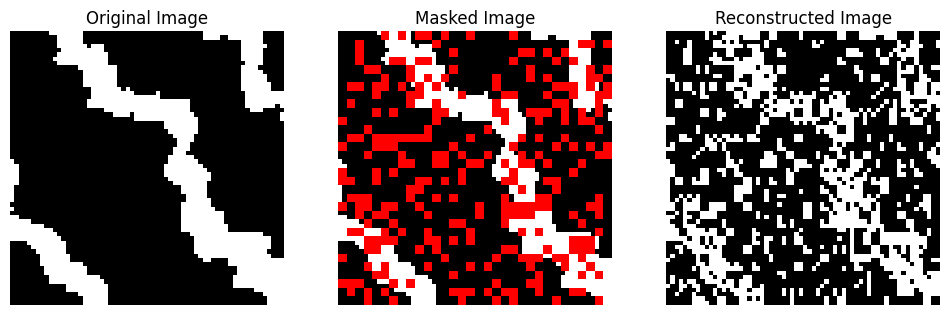

Epoch [23/1000] completed. Average Loss: 1.4386


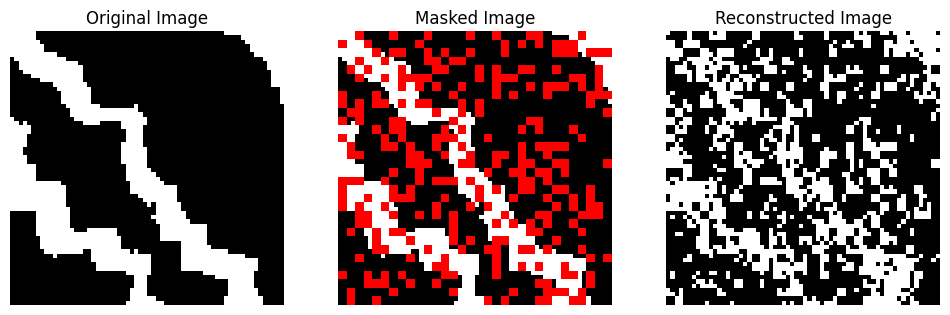

Epoch [24/1000] completed. Average Loss: 1.4240


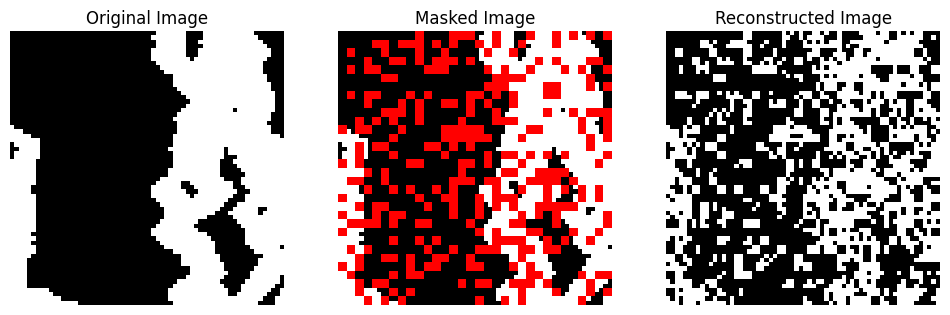

Epoch [25/1000] completed. Average Loss: 1.4073


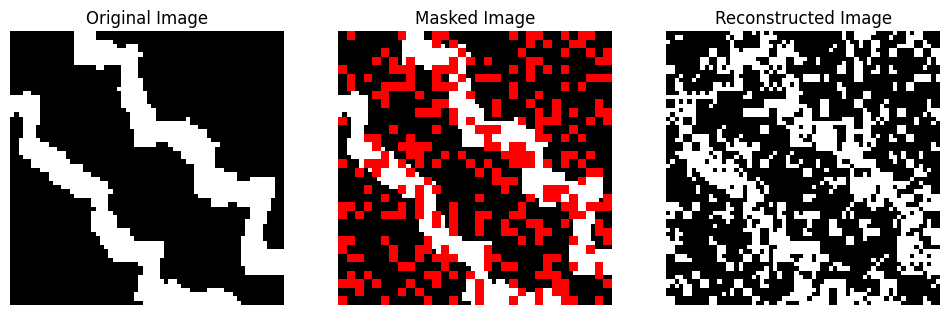

Epoch [26/1000] completed. Average Loss: 1.4081


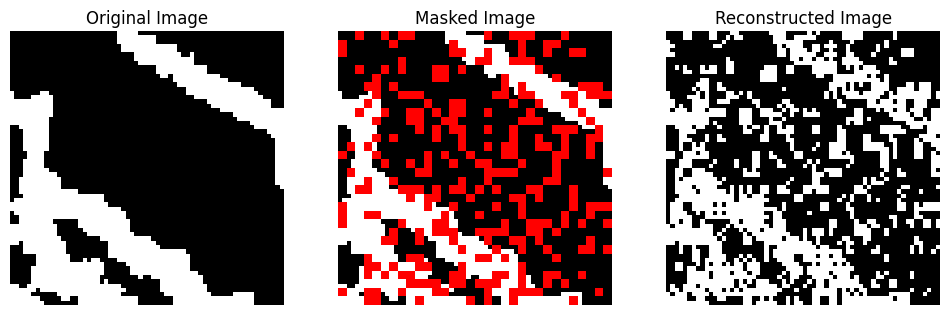

Epoch [27/1000] completed. Average Loss: 1.3833


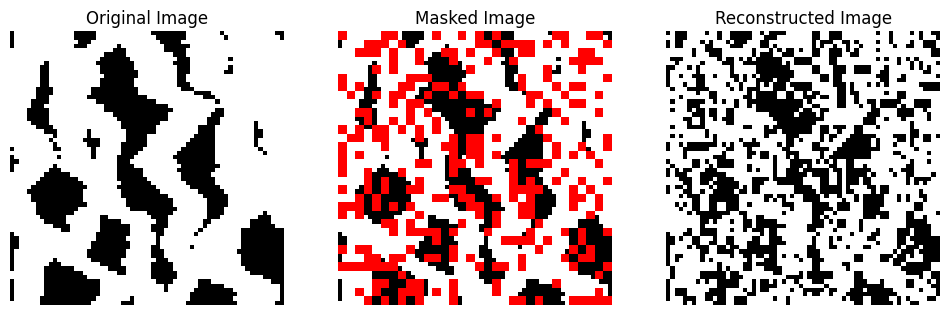

Epoch [28/1000] completed. Average Loss: 1.3827


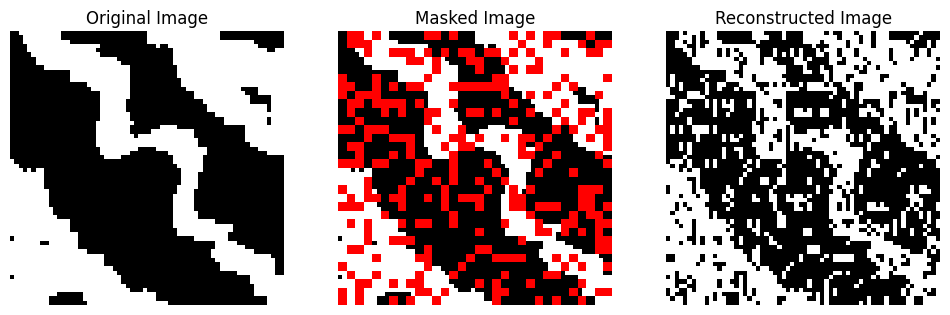

Epoch [29/1000] completed. Average Loss: 1.3740


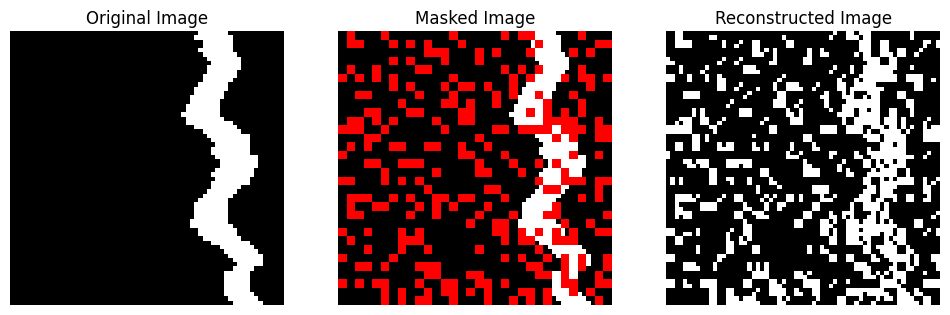

Epoch [30/1000] completed. Average Loss: 1.3647


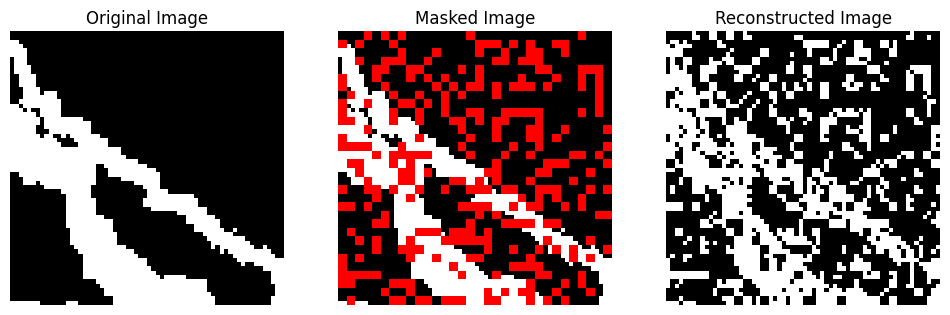

Epoch [31/1000] completed. Average Loss: 1.3533


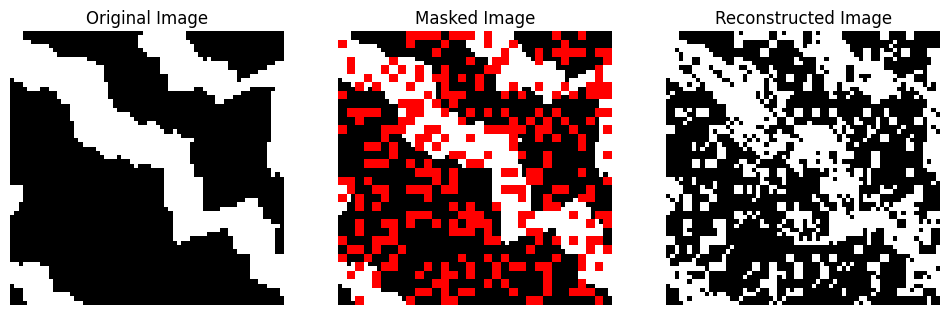

Epoch [32/1000] completed. Average Loss: 1.3340


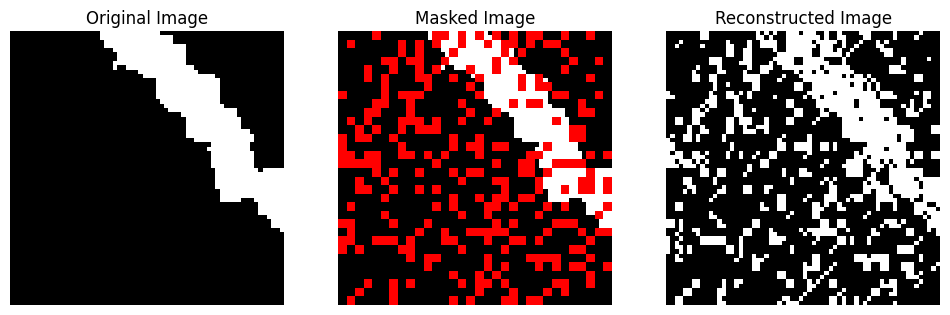

Epoch [33/1000] completed. Average Loss: 1.3361


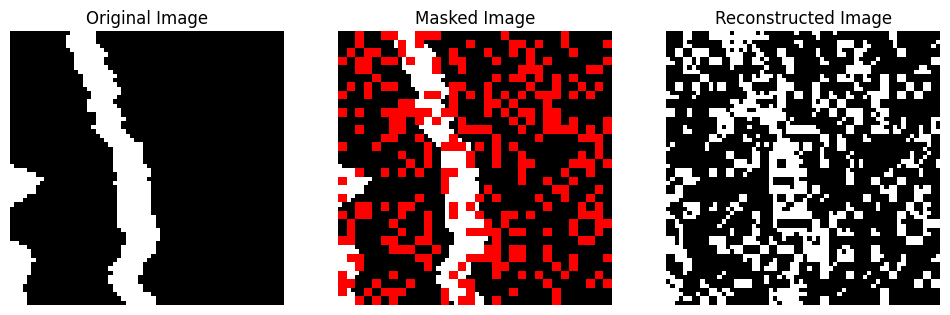

Epoch [34/1000] completed. Average Loss: 1.3271


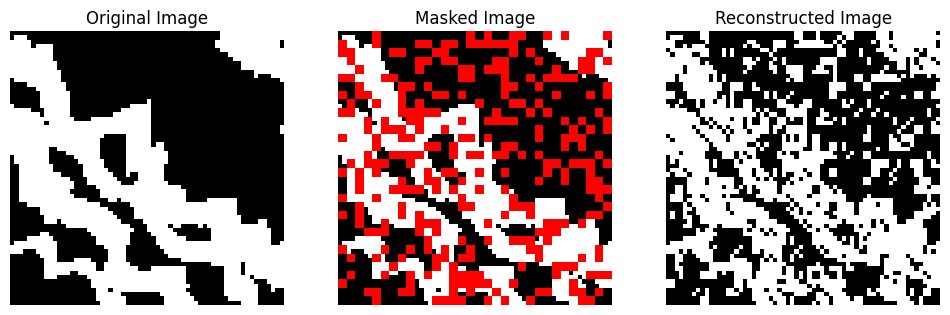

Epoch [35/1000] completed. Average Loss: 1.3180


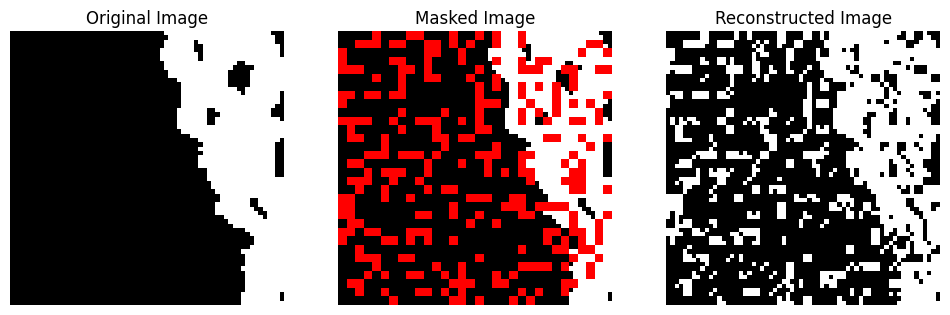

Epoch [36/1000] completed. Average Loss: 1.3056


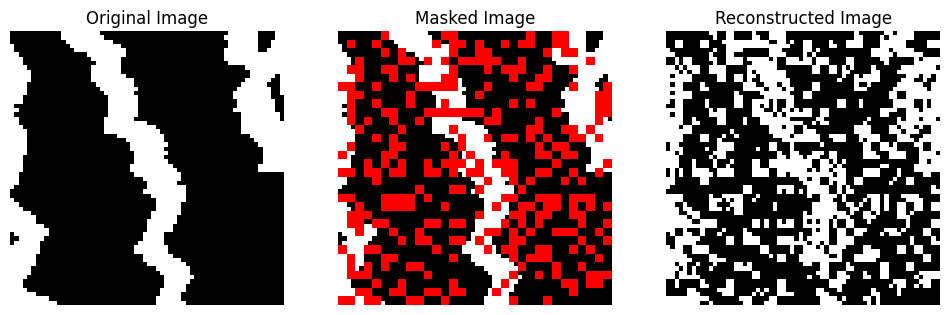

Epoch [37/1000] completed. Average Loss: 1.2905


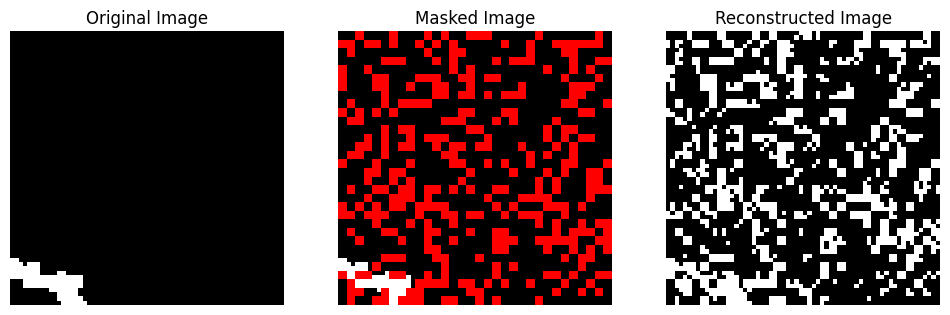

Epoch [38/1000] completed. Average Loss: 1.2825


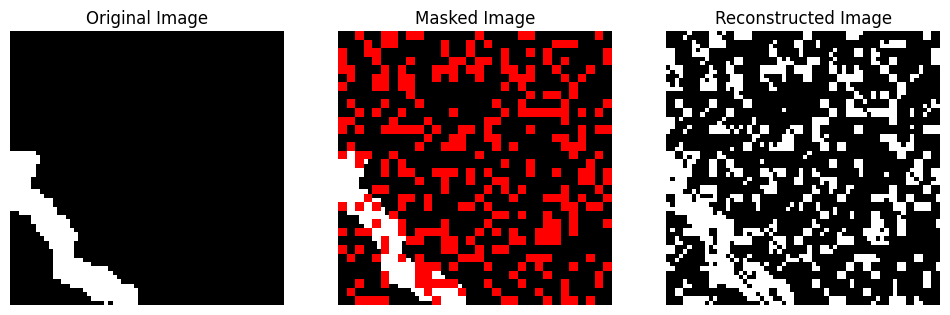

Epoch [39/1000] completed. Average Loss: 1.2767


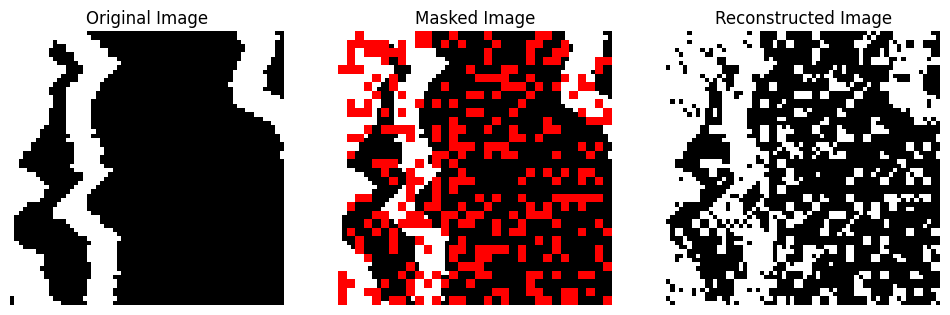

Epoch [40/1000] completed. Average Loss: 1.2779


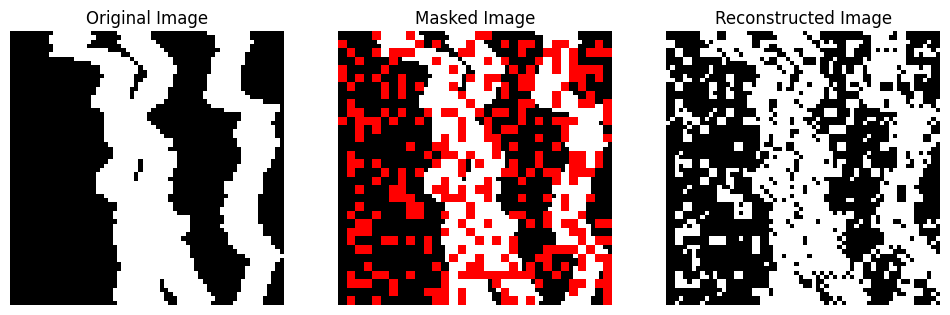

Epoch [41/1000] completed. Average Loss: 1.2719


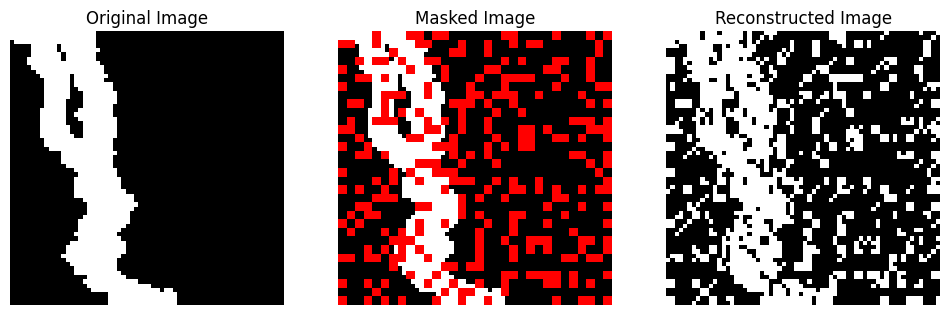

Epoch [42/1000] completed. Average Loss: 1.2465


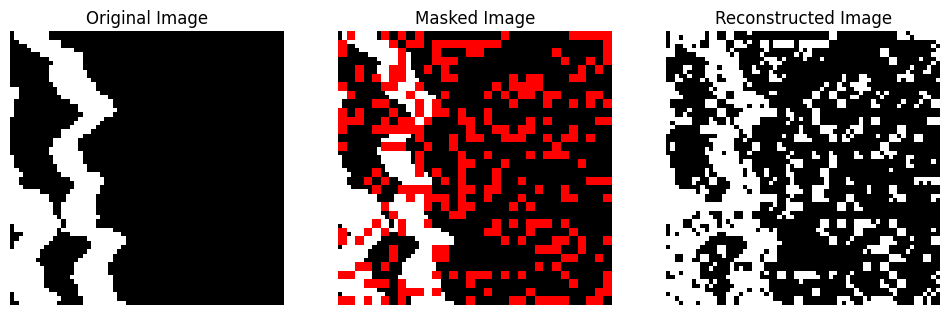

Epoch [43/1000] completed. Average Loss: 1.2425


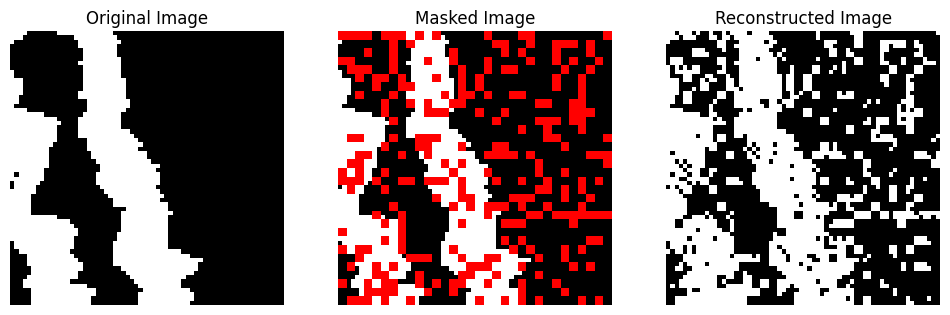

Epoch [44/1000] completed. Average Loss: 1.2392


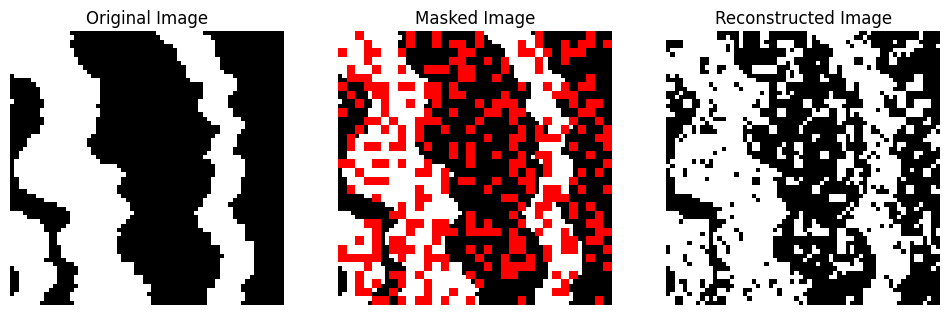

Epoch [45/1000] completed. Average Loss: 1.2247


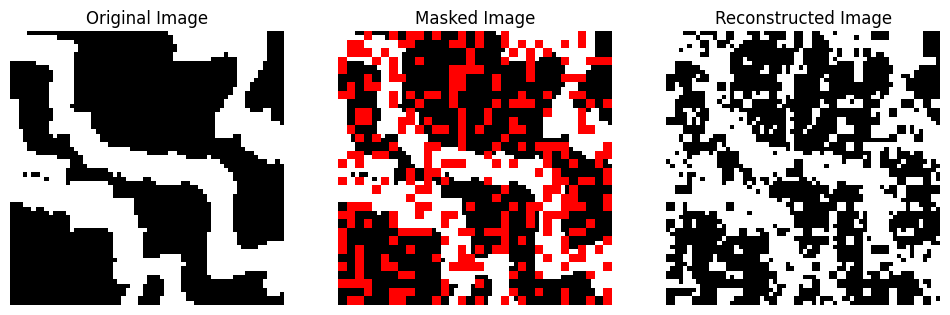

Epoch [46/1000] completed. Average Loss: 1.2254


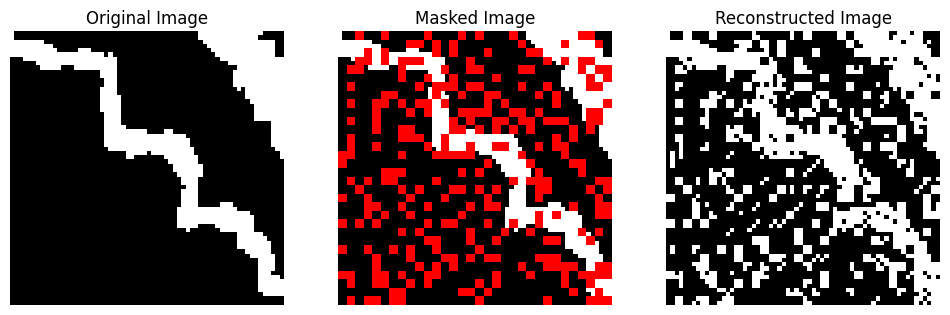

Epoch [47/1000] completed. Average Loss: 1.2158


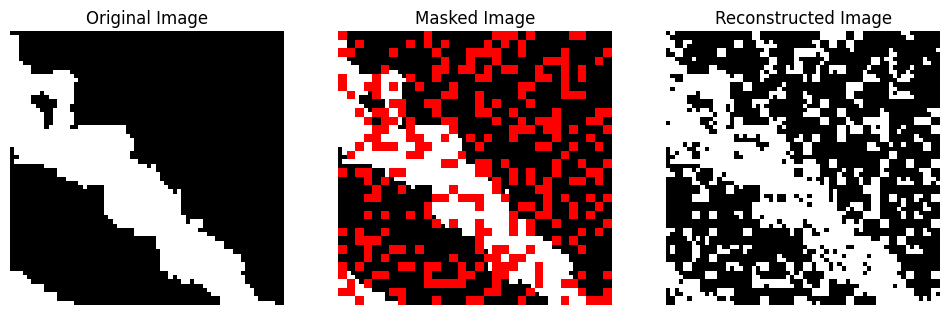

Epoch [48/1000] completed. Average Loss: 1.2088


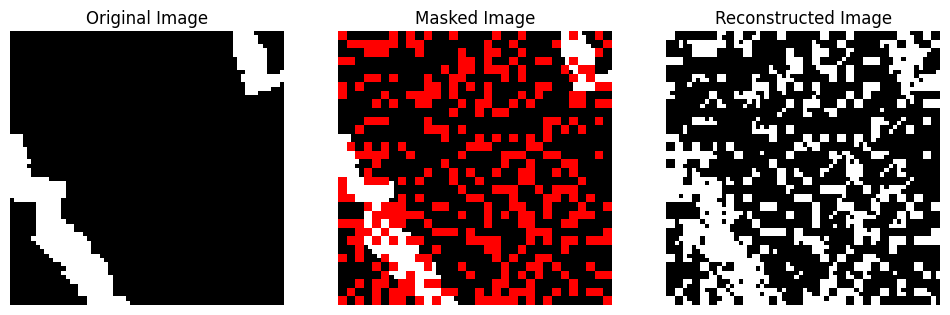

Epoch [49/1000] completed. Average Loss: 1.2044


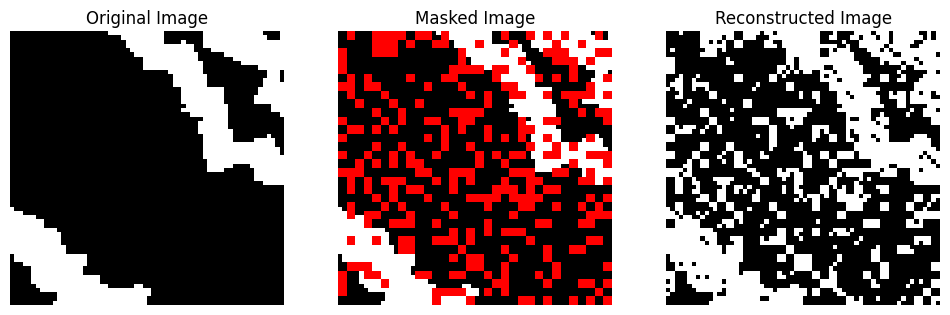

Epoch [50/1000] completed. Average Loss: 1.2028
Checkpoint saved for epoch 50


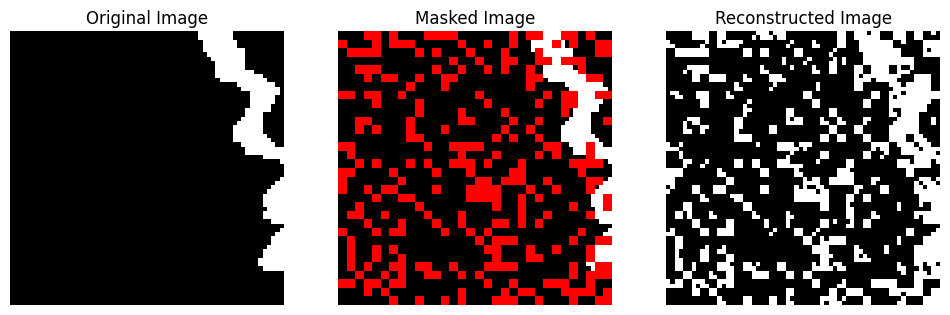

Epoch [51/1000] completed. Average Loss: 1.1862


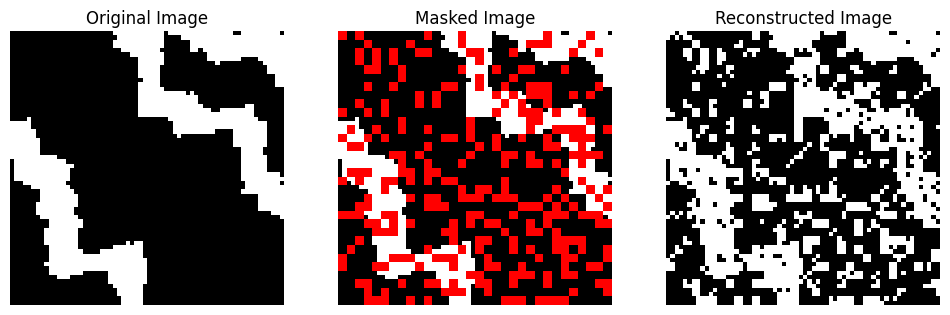

Epoch [52/1000] completed. Average Loss: 1.1709


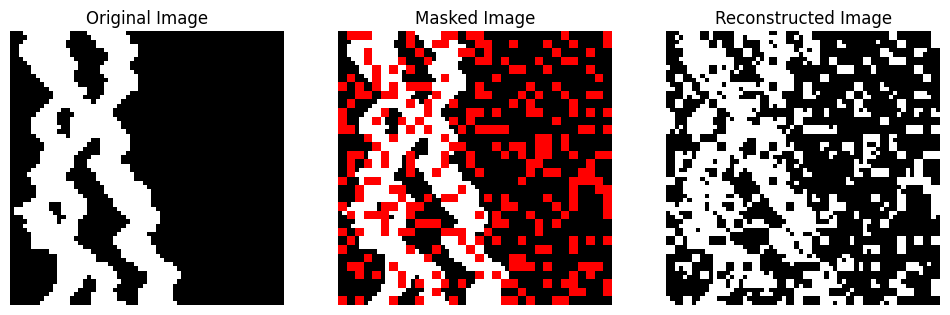

Epoch [53/1000] completed. Average Loss: 1.1739


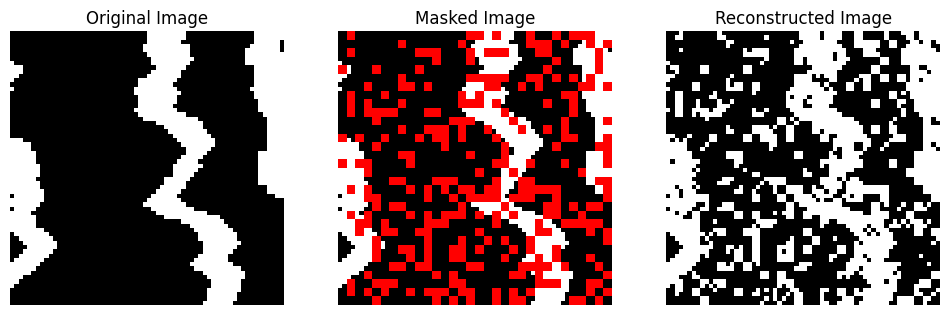

Epoch [54/1000] completed. Average Loss: 1.1656


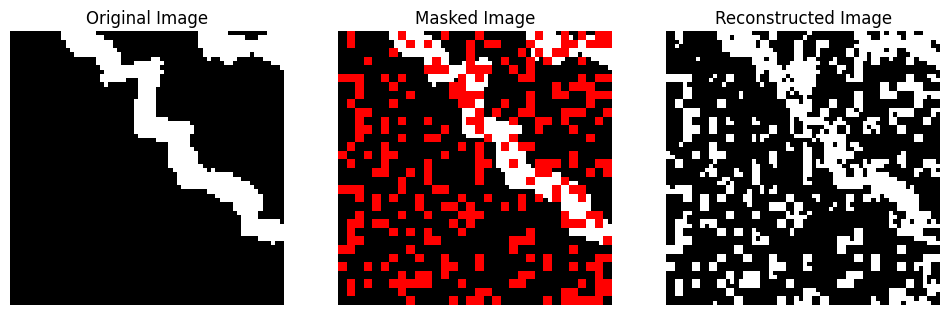

Epoch [55/1000] completed. Average Loss: 1.1680


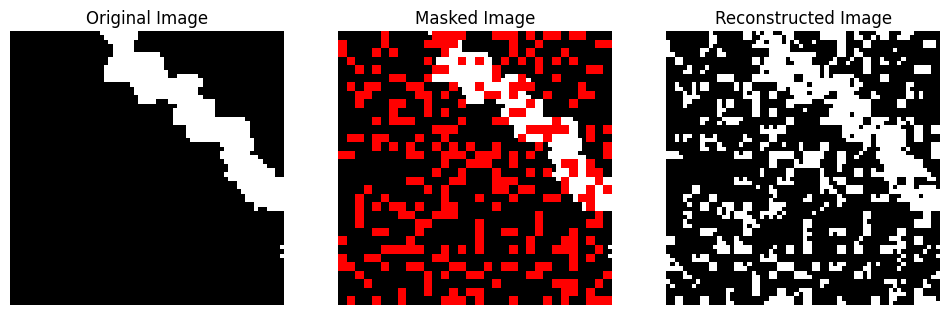

Epoch [56/1000] completed. Average Loss: 1.1583


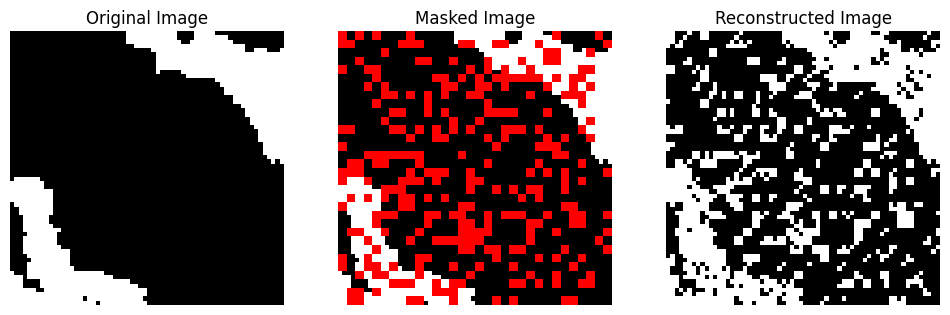

Epoch [57/1000] completed. Average Loss: 1.1566


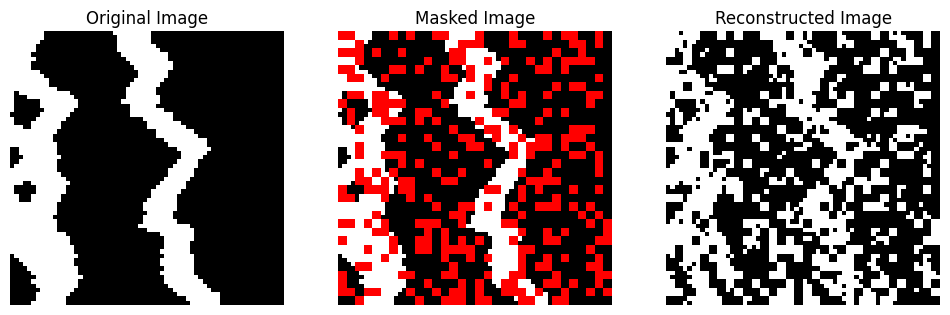

Epoch [58/1000] completed. Average Loss: 1.1335


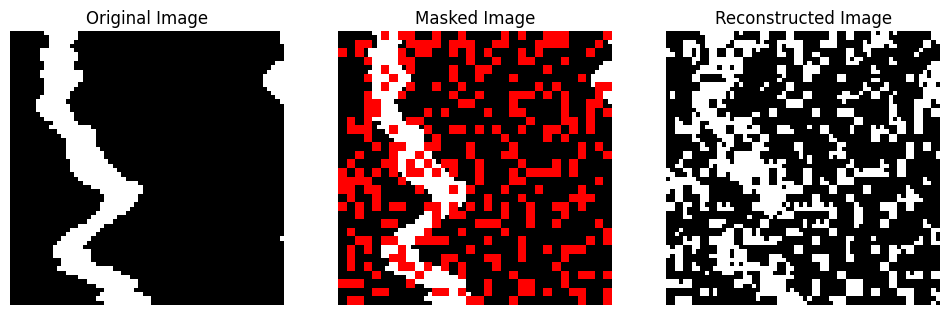

Epoch [59/1000] completed. Average Loss: 1.1353


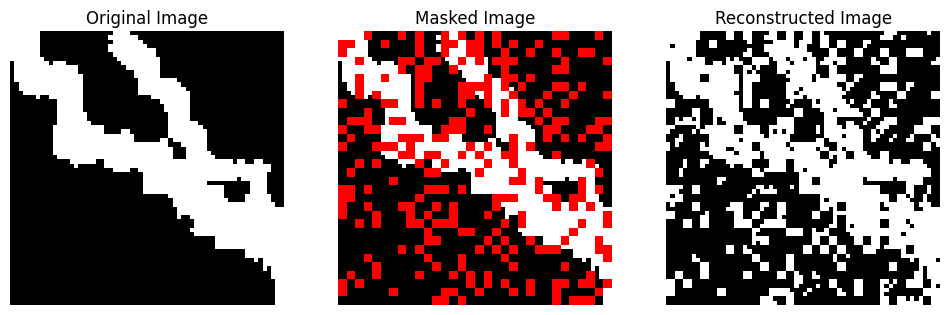

Epoch [60/1000] completed. Average Loss: 1.1331


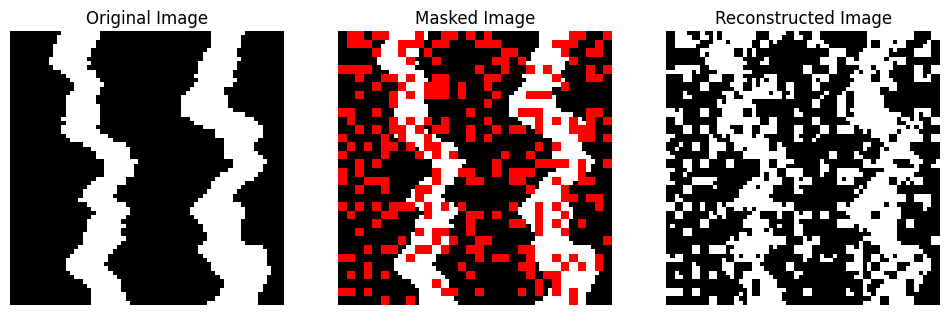

Epoch [61/1000] completed. Average Loss: 1.1238


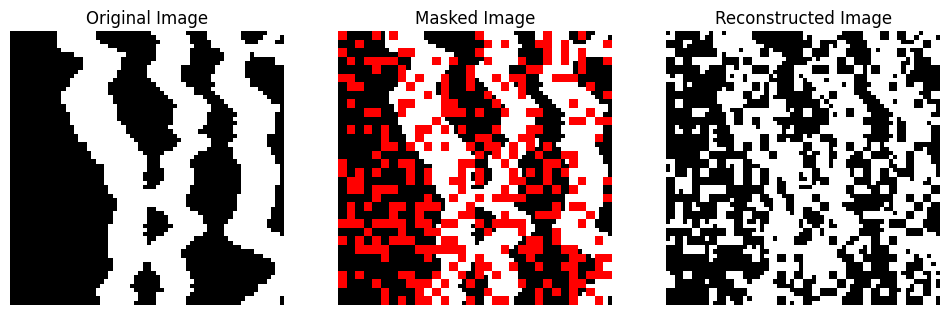

Epoch [62/1000] completed. Average Loss: 1.1138


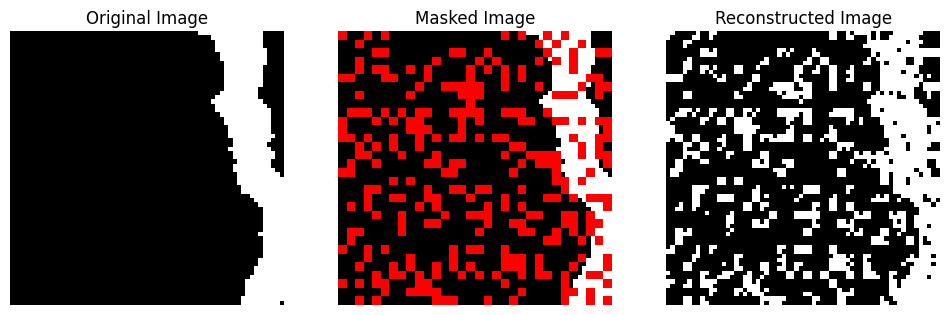

Epoch [63/1000] completed. Average Loss: 1.1180


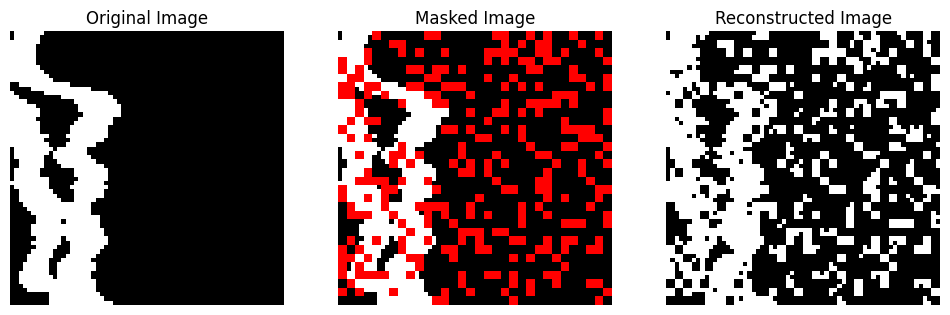

Epoch [64/1000] completed. Average Loss: 1.1145


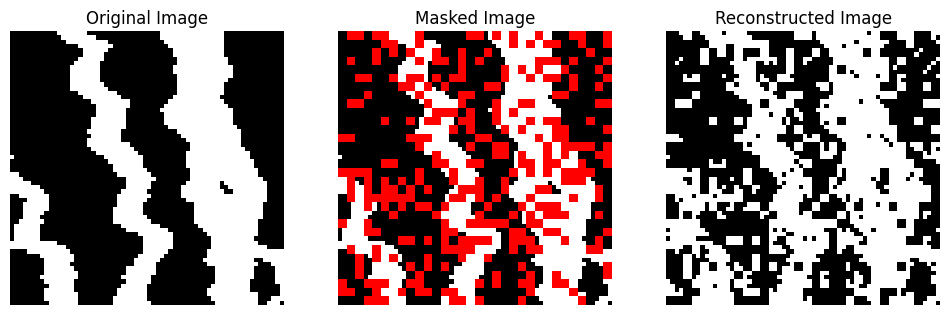

Epoch [65/1000] completed. Average Loss: 1.1219


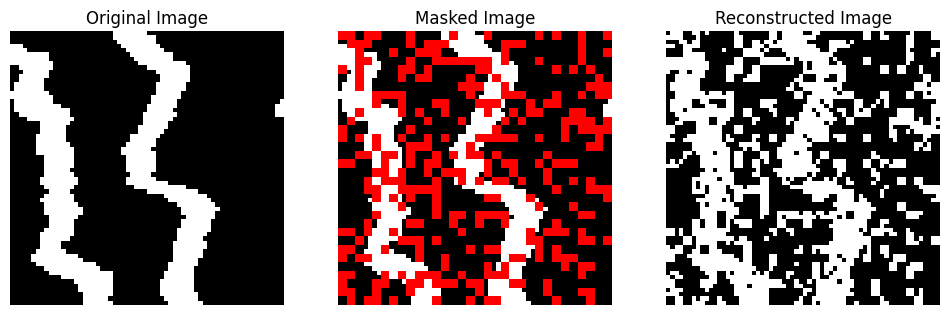

Epoch [66/1000] completed. Average Loss: 1.1102


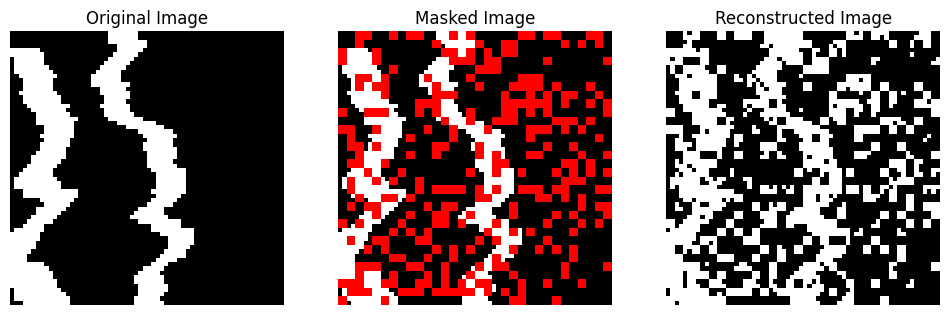

Epoch [67/1000] completed. Average Loss: 1.1109


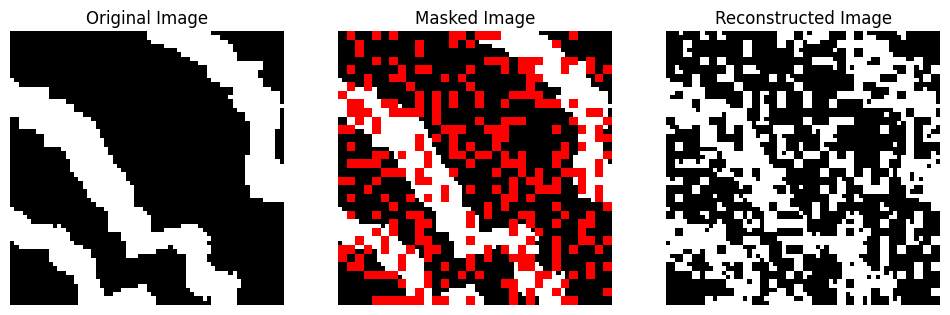

Epoch [68/1000] completed. Average Loss: 1.0962


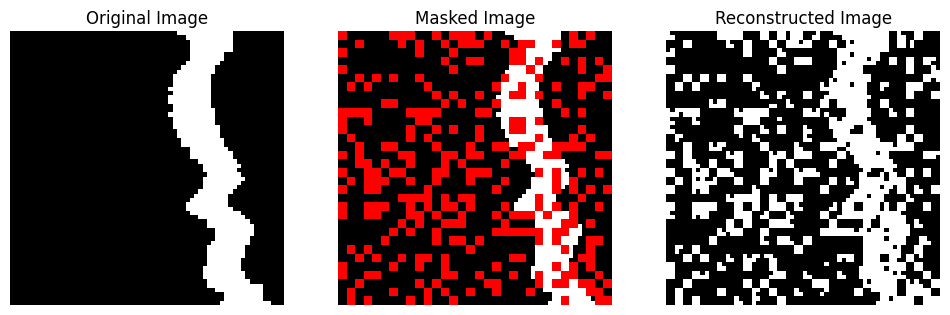

Epoch [69/1000] completed. Average Loss: 1.1093


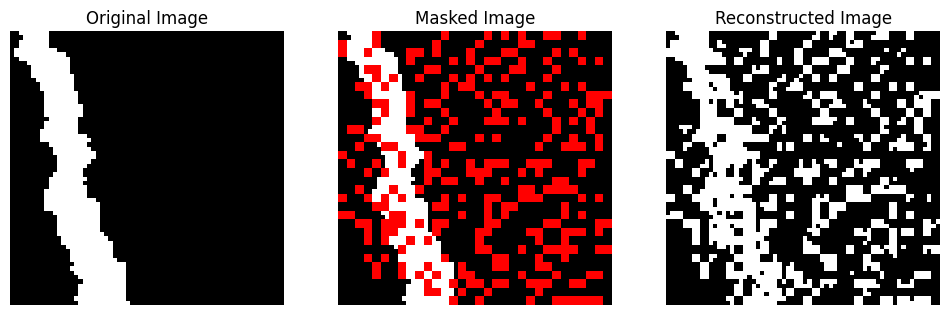

Epoch [70/1000] completed. Average Loss: 1.0985


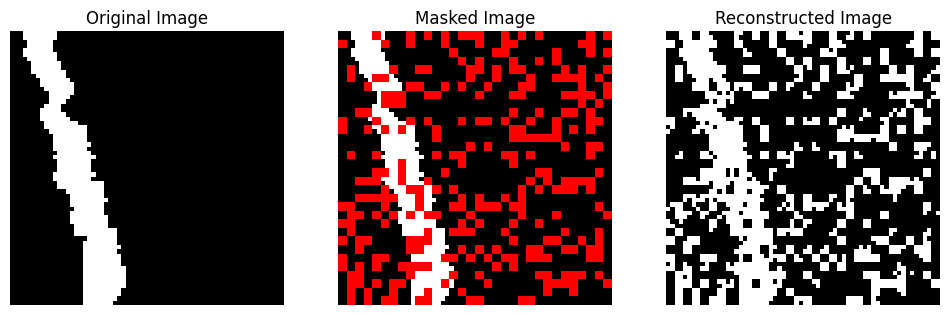

Epoch [71/1000] completed. Average Loss: 1.0986


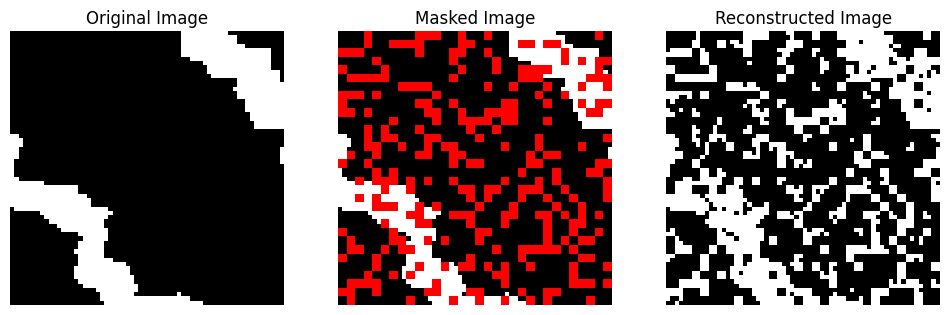

Epoch [72/1000] completed. Average Loss: 1.0845


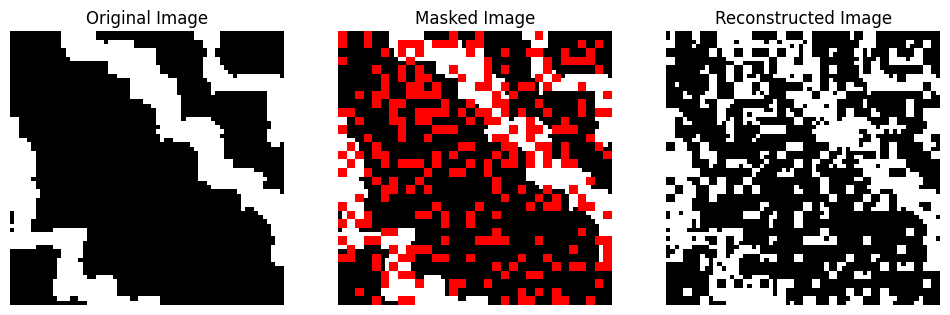

Epoch [73/1000] completed. Average Loss: 1.0771


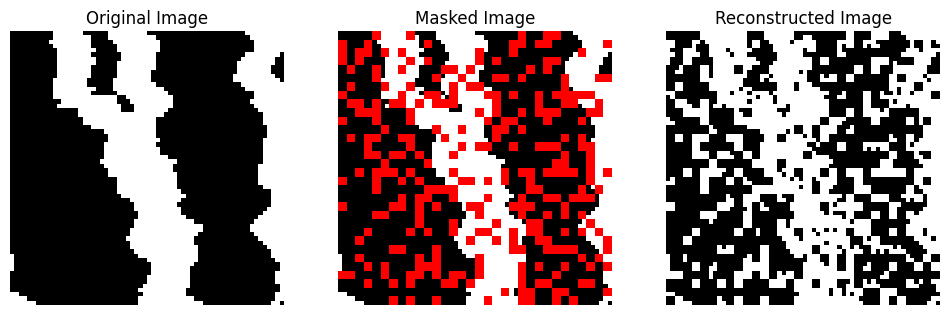

In [ ]:
# Convert to tensors, should be type Long
training_images = torch.tensor(training_data, dtype=torch.long)
test_images = torch.tensor(test_data, dtype=torch.long)

# Parameters
batch_size = 64
embed_dim = 4
num_heads = 1
feedforward_dim = 8
num_layers = 2
num_tokens = 17  # 16 tokens + 1 mask token
max_patches = 32 * 32
dropout = 0.3
learning_rate = 5e-4
num_epochs = 300
initial_mask_rate = 0.2
final_mask_rate = 0.1

# Dataset and DataLoader
dataset = BinaryImageDataset(training_images)  # Assumes training_images is already loaded
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
model = VisionTransformer(embed_dim, num_heads, feedforward_dim, num_layers, num_tokens, max_patches, dropout).to(device)

# Define optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

# Early stopping
class EarlyStopping:
    def __init__(self, patience=20):
        self.patience = patience
        self.best_loss = None
        self.counter = 0

    def __call__(self, validation_loss):
        if self.best_loss is None or validation_loss < self.best_loss:
            self.best_loss = validation_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

early_stopping = EarlyStopping()

# Custom colormap for visualization
cmap = colors.ListedColormap(['red', 'black', 'white'])  # Red for masked, black for 0, white for 1
bounds = [-1.5, -0.5, 0.5, 1.5]
norm = colors.BoundaryNorm(bounds, cmap.N)

# Directory to save checkpoints
os.makedirs("checkpoints", exist_ok=True)

# Training Loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    current_mask_rate = initial_mask_rate - (epoch / num_epochs) * (initial_mask_rate - final_mask_rate)

    for batch_idx, images in enumerate(dataloader):
        # Preprocess images
        patch_indices = torch.stack([preprocess_image(img) for img in images]).long()
        masked_patches = patch_indices.clone()

        # Masking
        mask = torch.rand(masked_patches.shape) < current_mask_rate
        masked_patches[mask] = num_tokens - 1

        # Calculate token weights dynamically
        token_counts = torch.bincount(patch_indices.view(-1), minlength=num_tokens)
        mask_token_count = mask.sum().item()
        token_counts[-1] = mask_token_count
        token_weights = 1.0 / (token_counts + 1e-6)
        token_weights = token_weights / token_weights.sum()
        token_weights = token_weights.to(device)

        # Define weighted CrossEntropyLoss
        criterion = nn.CrossEntropyLoss(weight=token_weights)

        # Move to device
        masked_patches, patch_indices, mask = (
            masked_patches.to(device),
            patch_indices.to(device),
            mask.to(device),
        )

        # Forward pass
        logits = model(masked_patches, mask)
        loss = criterion(logits.view(-1, num_tokens), patch_indices.view(-1))

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Log batch metrics
        wandb.log({"batch_loss": loss.item()})

        # Visualization for the first batch in the epoch
        if batch_idx == 0:
            with torch.no_grad():
                predicted_indices = torch.argmax(logits, dim=-1).cpu()[0]
                reconstructed_image = reconstruct_image_from_patches(predicted_indices)

                visualized_masked_patches = masked_patches.cpu()[0].clone()
                visualized_masked_patches[visualized_masked_patches == num_tokens - 1] = -1
                masked_image = reconstruct_image_from_patches(visualized_masked_patches)

                # Log visualizations to wandb
                wandb.log({
                    "Original Image": wandb.Image(
                        reconstruct_image_from_patches(patch_indices.cpu()[0])
                    ),
                    "Masked Image": wandb.Image(masked_image, caption="Masked Image"),
                    "Reconstructed Image": wandb.Image(
                        reconstructed_image, caption="Reconstructed Image"
                    ),
                })

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] completed. Average Loss: {avg_loss:.4f}")

    # Log epoch metrics
    wandb.log({"epoch_loss": avg_loss, "mask_rate": current_mask_rate})

    # Scheduler step
    scheduler.step(avg_loss)

    # Early stopping check
    if early_stopping(avg_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

    # Save checkpoint periodically
    if (epoch + 1) % 50 == 0:
        checkpoint_path = f"checkpoints/vision_transformer_epoch_{epoch+1}.pth"
        torch.save(
            {
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": avg_loss,
            },
            checkpoint_path,
        )
        print(f"Checkpoint saved for epoch {epoch+1}")
        wandb.save(checkpoint_path)

# Save the final model
torch.save(model.state_dict(), "vision_transformer_final_balanced.pth")
wandb.save("vision_transformer_final_balanced.pth")
print("Final model saved as 'vision_transformer_final_balanced.pth'.")
wandb.finish()

# Sampling